# Assignment 1


In [34]:
import numpy as np
np.random.seed(13) #TODO Check if this is used for sgd
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Reshape, Lambda
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing import sequence
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors as nn
from matplotlib import pylab
from __future__ import division

In [35]:
# DO NOT Modify the lines in this cell
path = 'alice.txt'
corpus = open(path).readlines()[0:700]

corpus = [sentence for sentence in corpus if sentence.count(" ") >= 2]

tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'+"'")
tokenizer.fit_on_texts(corpus)
corpus = tokenizer.texts_to_sequences(corpus)
nb_samples = sum(len(s) for s in corpus)
V = len(tokenizer.word_index) + 1

# Is this something they need to change?
dim = 100
window_size = 2 #use this window size for Skipgram, CBOW, and the model with the additional hidden layer
window_size_corpus = 4 #use this window size for the co-occurrence matrix

## Question 1

### Co-occurrence Matrix
Use the provided code to load the "Alice in Wonderland" text document. 
1. Implement the word-word co-occurrence matrix for “Alice in Wonderland”
2. Normalize the words such that every value lies within a range of 0 and 1
3. Compute the cosine distance between the given words:
    - Alice 
    - Dinah
    - Rabbit
4. List the 5 closest words to 'Alice'. Discuss the results.
5. Discuss what the main drawbacks are of a term-term co-occurence matrix solutions?


In [46]:
#create co-occurrence matrix

In [47]:
#find cosine similarity to Alice, Dinah and Rabbit

In [48]:
#find the closest words to Alice

Discussion of the drawbacks:

In [32]:
#Save your all the vector representations of your word embeddings in this way
#Change when necessary the sizes of the vocabulary/embedding dimension

f = open('vectors_co_occurrence.txt',"w")
f.write(" ".join([str(V-1),str(V-1)]))
f.write("\n")

#vectors = your word co-occurrence matrix
vectors = []
for word, i in tokenizer.word_index.items():    
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(vectors[i,:]))))
    f.write("\n")
f.close()

NameError: name 'V' is not defined

In [ ]:
#reopen your file as follows

co_occurrence = KeyedVectors.load_word2vec_format('./vectors_co_occurrence.txt', binary=False)

## Question 2

### Word embeddings
Build embeddings with a keras implementation where the embedding vector is of length 50, 150 and 300. Use the Alice in Wonderland text book for training.
1. Using the CBOW model
2. Using Skipgram model
3. Add extra hidden dense layer to CBow and Skipgram implementations. Choose an activation function for that layer and justify your answer.
4. Analyze the four different word embeddings
    - Implement your own function to perform the analogy task with. Do not use existing libraries for this task such as Gensim. Your function should be able to answer whether an anaology as in the example given in the pdf-file is true.
    - Compare the performance on the analogy task between the word embeddings that you have trained in 2.1, 2.2 and 2.3.  
    - Visualize your results and interpret your results
5. Use the word co-occurence matrix from Question 1. Compare the performance on the analogy task with the performance of your trained word embeddings.  
6. Discuss:
    - What are the main advantages of CBOW and Skipgram?
    - What is the advantage of negative sampling?
    - What are the main drawbacks of CBOW and Skipgram?
7. Load pre-trained embeddings on large corpuses (see the pdf file). You only have to consider the word embeddings with an embedding size of 300
    - Compare performance on the analogy task with your own trained embeddings from "Alice in Wonderland". You can limit yourself to the vocabulary of Alice in Wonderland. Visualize the pre-trained word embeddings and compare these with the results of your own trained word embeddings. 


In [36]:
#prepare data for cbow

def generate_data(corpus, window_size, V):
    maxlen = window_size*2
    for words in corpus:
        L = len(words)
        for index, word in enumerate(words):
            contexts = []
            labels   = []            
            s = index - window_size
            e = index + window_size + 1
            
            contexts.append([words[i] for i in range(s, e) if 0 <= i < L and i != index])
            labels.append(word)

            x = sequence.pad_sequences(contexts, maxlen=maxlen)
            y = np_utils.to_categorical(labels, V)
            yield (x, y)

In [37]:
#create CBOW model
dim=50
cbow50 = Sequential()
cbow50.add(Embedding(input_dim=V, output_dim=dim, input_length=window_size*2))
cbow50.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim,)))
cbow50.add(Dense(V, activation='softmax'))

dim=150
cbow150 = Sequential()
cbow150.add(Embedding(input_dim=V, output_dim=dim, input_length=window_size*2))
cbow150.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim,)))
cbow150.add(Dense(V, activation='softmax'))

dim=300
cbow300 = Sequential()
cbow300.add(Embedding(input_dim=V, output_dim=dim, input_length=window_size*2))
cbow300.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim,)))
cbow300.add(Dense(V, activation='softmax'))

In [38]:
#define loss function
loss='categorical_crossentropy'

In [39]:
#train cbow50 model
cbow50.compile(loss=loss, optimizer='adadelta')

for ite in range(3):
    loss = 0.
    for x, y in generate_data(corpus, window_size, V):
        loss += cbow50.train_on_batch(x, y)

    print(ite, loss)
    
    
f = open('cbow_50_vectors.txt' ,'w')
f.write('{} {}\n'.format(V-1, 50))
vectors = cbow50.get_weights()[0]
for word, i in tokenizer.word_index.items():
    str_vec = ' '.join(map(str, list(vectors[i, :])))
    f.write('{} {}\n'.format(word, str_vec))
f.close()

0 41686.856939315796
1 39117.07975804806
2 38908.93960213661


In [40]:
#train cbow150 model
loss='categorical_crossentropy'
cbow150.compile(loss=loss, optimizer='adadelta')

for ite in range(3):
    loss = 0.
    for x, y in generate_data(corpus, window_size, V):
        loss += cbow150.train_on_batch(x, y)

    print(ite, loss)
    
    
f = open('cbow_150_vectors.txt' ,'w')
f.write('{} {}\n'.format(V-1, 150))
vectors = cbow150.get_weights()[0]
for word, i in tokenizer.word_index.items():
    str_vec = ' '.join(map(str, list(vectors[i, :])))
    f.write('{} {}\n'.format(word, str_vec))
f.close()

0 41624.23085522652
1 38758.48308968544
2 38354.18330681324


In [41]:
#train cbow300 model
loss='categorical_crossentropy'
cbow300.compile(loss=loss, optimizer='adadelta')

for ite in range(3):
    loss = 0.
    for x, y in generate_data(corpus, window_size, V):
        loss += cbow300.train_on_batch(x, y)

    print(ite, loss)
    
f = open('cbow_300_vectors.txt' ,'w')
f.write('{} {}\n'.format(V-1, 300))
vectors = cbow300.get_weights()[0]
for word, i in tokenizer.word_index.items():
    str_vec = ' '.join(map(str, list(vectors[i, :])))
    f.write('{} {}\n'.format(word, str_vec))
f.close()

0 41559.90414094925
1 38492.52104020119
2 37942.09509307146


In [42]:
#prepare data for Skipgram

def generate_data_skipgram(corpus, window_size, V):
    maxlen = window_size*2
    all_in = []
    all_out = []
    for words in corpus:
        L = len(words)
        for index, word in enumerate(words):
            p = index - window_size
            n = index + window_size + 1
                    
            in_words = []
            labels = []
            for i in range(p, n):
                if i != index and 0 <= i < L:
                    in_words.append([word])
                    labels.append(words[i])
            if in_words != []:
                all_in.append(np.array(in_words,dtype=np.int32))
                all_out.append(np_utils.to_categorical(labels, V))
    return (all_in,all_out)

#get x and y's for data
x,y = generate_data_skipgram(corpus,window_size,V)

#save the preprocessed data of Skipgram
f = open('data_skipgram.txt' ,'w')

for inputs, outcome in zip(x,y):
    inputs = np.concatenate(inputs)
    f.write(" ".join(map(str, list(inputs))))
    f.write(",")
    outcome = np.concatenate(outcome)
    f.write(" ".join(map(str,list(outcome))))
    f.write("\n")
f.close()

In [43]:
#load the preprocessed Skipgram data
def generate_data_skipgram_from_file():
    f = open('data_skipgram.txt' ,'r')
    for row in f:
        inputs,outputs = row.split(",")
        inputs = np.fromstring(inputs, dtype=int, sep=' ')
        inputs = np.asarray(np.split(inputs, len(inputs)))
        outputs = np.fromstring(outputs, dtype=float, sep=' ')
        outputs = np.asarray(np.split(outputs, len(inputs)))
        yield (inputs,outputs)

In [44]:
#create Skipgram model
dim=50
skipgram50 = Sequential()
skipgram50.add(Embedding(input_dim=V, output_dim=dim, embeddings_initializer='glorot_uniform', input_length=1))
skipgram50.add(Reshape((dim, )))
skipgram50.add(Dense(input_dim=dim, units=V, kernel_initializer='uniform', activation='softmax'))

dim=150
skipgram150 = Sequential()
skipgram150.add(Embedding(input_dim=V, output_dim=dim, embeddings_initializer='glorot_uniform', input_length=1))
skipgram150.add(Reshape((dim, )))
skipgram150.add(Dense(input_dim=dim, units=V, kernel_initializer='uniform', activation='softmax'))

dim=300
skipgram300 = Sequential()
skipgram300.add(Embedding(input_dim=V, output_dim=dim, embeddings_initializer='glorot_uniform', input_length=1))
skipgram300.add(Reshape((dim, )))
skipgram300.add(Dense(input_dim=dim, units=V, kernel_initializer='uniform', activation='softmax'))

In [45]:
#define loss function for Skipgram

In [46]:
#train Skipgram50 model

skipgram50.compile(loss='categorical_crossentropy', optimizer='adadelta')

for ite in range(3):
    loss = 0.
    for x, y in generate_data_skipgram_from_file():
        loss += skipgram50.train_on_batch(x, y)

    print(ite, loss)
    
f = open('skipgram_50_vectors.txt' ,'w')
f.write('{} {}\n'.format(V-1, 50))
vectors = skipgram50.get_weights()[0]
for word, i in tokenizer.word_index.items():
    str_vec = ' '.join(map(str, list(vectors[i, :])))
    f.write('{} {}\n'.format(word, str_vec))
f.close()

0 41271.78884887695
1 39101.341372966766
2 39265.00240945816


In [47]:
#train Skipgram150 model
loss='categorical_crossentropy'
skipgram150.compile(loss=loss, optimizer='adadelta')

for ite in range(3):
    loss = 0.
    for x, y in generate_data_skipgram_from_file():
        loss += skipgram150.train_on_batch(x, y)

    print(ite, loss)
    
f = open('skipgram_150_vectors.txt' ,'w')
f.write('{} {}\n'.format(V-1, 150))
vectors = skipgram150.get_weights()[0]
for word, i in tokenizer.word_index.items():
    str_vec = ' '.join(map(str, list(vectors[i, :])))
    f.write('{} {}\n'.format(word, str_vec))
f.close()

0 41215.38952541351
1 38922.67157101631
2 38985.02361166477


In [48]:
#train Skipgram300 model
loss='categorical_crossentropy'
skipgram300.compile(loss=loss, optimizer='adadelta')

for ite in range(3):
    loss = 0.
    for x, y in generate_data_skipgram_from_file():
        loss += skipgram300.train_on_batch(x, y)

    print(ite, loss)
    
f = open('skipgram_300_vectors.txt' ,'w')
f.write('{} {}\n'.format(V-1, 300))
vectors = skipgram300.get_weights()[0]
for word, i in tokenizer.word_index.items():
    str_vec = ' '.join(map(str, list(vectors[i, :])))
    f.write('{} {}\n'.format(word, str_vec))
f.close()

0 41158.67087030411
1 38737.37133550644
2 38703.309982299805


In [63]:
#create CBOW model with additional dense layer
dim=50
cbow50h = Sequential()
cbow50h.add(Embedding(input_dim=V, output_dim=dim, input_length=window_size*2))
cbow50h.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim,)))
cbow50h.add(Dense(V, activation='relu'))
cbow50h.add(Dense(V, activation='softmax'))

dim=150
cbow150h = Sequential()
cbow150h.add(Embedding(input_dim=V, output_dim=dim, input_length=window_size*2))
cbow150h.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim,)))
cbow150h.add(Dense(V, activation='relu'))
cbow150h.add(Dense(V, activation='softmax'))

dim=300
cbow300h = Sequential()
cbow300h.add(Embedding(input_dim=V, output_dim=dim, input_length=window_size*2))
cbow300h.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim,)))
cbow300h.add(Dense(V, activation='relu'))
cbow300h.add(Dense(V, activation='softmax'))

In [64]:
#define loss function for CBOW + dense


In [66]:
#train model for CBOW + dense
loss='categorical_crossentropy'
cbow50h.compile(loss=loss, optimizer='adadelta')

for ite in range(3):
    loss = 0.
    for x, y in generate_data(corpus, window_size, V):
        loss += cbow50h.train_on_batch(x, y)

    print(ite, loss)
    
f = open('cbowh_50_vectors.txt' ,'w')
f.write('{} {}\n'.format(V-1, 50))
vectors = cbow50h.get_weights()[0]
for word, i in tokenizer.word_index.items():
    str_vec = ' '.join(map(str, list(vectors[i, :])))
    f.write('{} {}\n'.format(word, str_vec))
f.close()



0 38203.86327829957
1 38013.09641942382
2 37855.625559709966


In [67]:
loss='categorical_crossentropy'
cbow150h.compile(loss=loss, optimizer='adadelta')

for ite in range(3):
    loss = 0.
    for x, y in generate_data(corpus, window_size, V):
        loss += cbow150h.train_on_batch(x, y)

    print(ite, loss)
    
f = open('cbowh_150_vectors.txt' ,'w')
f.write('{} {}\n'.format(V-1, 150))
vectors = cbow150h.get_weights()[0]
for word, i in tokenizer.word_index.items():
    str_vec = ' '.join(map(str, list(vectors[i, :])))
    f.write('{} {}\n'.format(word, str_vec))
f.close()

0 39556.89970886707
1 38192.07329599559
2 37617.63297378272


In [69]:
loss='categorical_crossentropy'
cbow300h.compile(loss=loss, optimizer='adadelta')

for ite in range(3):
    loss = 0.
    for x, y in generate_data(corpus, window_size, V):
        loss += cbow300h.train_on_batch(x, y)

    print(ite, loss)
    
f = open('cbowh_300_vectors.txt' ,'w')
f.write('{} {}\n'.format(V-1, 300))
vectors = cbow300h.get_weights()[0]
for word, i in tokenizer.word_index.items():
    str_vec = ' '.join(map(str, list(vectors[i, :])))
    f.write('{} {}\n'.format(word, str_vec))
f.close()

0 37681.00657823682
1 37109.283381693065
2 36645.58560779132


In [142]:
#create Skipgram with additional dense layer
from keras.layers import Dropout

dropout_rate = 0.2
dim=50
skipgram50h = Sequential()
skipgram50h.add(Embedding(input_dim=V, output_dim=dim, embeddings_initializer='glorot_uniform', input_length=1))
skipgram50h.add(Reshape((dim, )))
skipgram50h.add(Dense(units=V, activation='relu'))
skipgram50h.add(Dense(units=V, kernel_initializer='uniform', activation='softmax'))
# dim=50
# skipgram50h = Sequential()
# skipgram50h.add(Embedding(input_dim=V, output_dim=dim, embeddings_initializer='glorot_uniform', input_length=1))
# skipgram50h.add(Dense(dim, activation='relu'))
# skipgram50h.add(Dense(dim, kernel_initializer='uniform', activation='softmax'))

dim=150
skipgram150h = Sequential()
skipgram150h.add(Embedding(input_dim=V, output_dim=dim, embeddings_initializer='glorot_uniform', input_length=1))
skipgram150h.add(Reshape((dim, )))
skipgram150h.add(Dense(units=V, activation='relu'))
skipgram150h.add(Dense(units=V, kernel_initializer='uniform', activation='softmax'))

dim=300
skipgram300h = Sequential()
skipgram300h.add(Embedding(input_dim=V, output_dim=dim, embeddings_initializer='glorot_uniform', input_length=1))
skipgram300h.add(Reshape((dim, )))
skipgram300h.add(Dense(units=V, activation='relu'))
skipgram300h.add(Dense(units=V, kernel_initializer='uniform', activation='softmax'))

In [143]:
#define loss function for Skipgram + dense


In [144]:
#train model for Skipgram + dense
skipgram50h.compile(loss='categorical_crossentropy', optimizer='adadelta')

for ite in range(3):
    loss = 0.
    for x, y in generate_data_skipgram_from_file():
        loss += skipgram50h.train_on_batch(x, y)

    print(ite, loss)
    
f = open('skipgramh_50_vectors.txt' ,'w')
f.write('{} {}\n'.format(V-1, 50))
vectors = skipgram50h.get_weights()[0]
for word, i in tokenizer.word_index.items():
    str_vec = ' '.join(map(str, list(vectors[i, :])))
    f.write('{} {}\n'.format(word, str_vec))
f.close()

0 38556.30892801285
1 38284.277649879456
2 38160.48908627033


In [145]:
loss='categorical_crossentropy'
skipgram150h.compile(loss=loss, optimizer='adadelta')

for ite in range(3):
    loss = 0.
    for x, y in generate_data_skipgram_from_file():
        loss += skipgram150h.train_on_batch(x, y)

    print(ite, loss)
    
f = open('skipgramh_150_vectors.txt' ,'w')
f.write('{} {}\n'.format(V-1, 150))
vectors = skipgram150h.get_weights()[0]
for word, i in tokenizer.word_index.items():
    str_vec = ' '.join(map(str, list(vectors[i, :])))
    f.write('{} {}\n'.format(word, str_vec))
f.close()

0 38524.81856560707
1 38182.9237254858
2 38044.449105620384


In [146]:
loss='categorical_crossentropy'
skipgram300h.compile(loss=loss, optimizer='adadelta')

for ite in range(3):
    loss = 0.
    for x, y in generate_data_skipgram_from_file():
        loss += skipgram300h.train_on_batch(x, y)

    print(ite, loss)
    
f = open('skipgramh_300_vectors.txt' ,'w')
f.write('{} {}\n'.format(V-1, 300))
vectors = skipgram300h.get_weights()[0]
for word, i in tokenizer.word_index.items():
    str_vec = ' '.join(map(str, list(vectors[i, :])))
    f.write('{} {}\n'.format(word, str_vec))
f.close()

0 38556.01204943657
1 38273.90782046318
2 38062.221319675446


In [49]:
#Implement your own analogy function

from math import *

#options: cbow_50, cbow_150, cbow_300, cbowh_50, cbowh_150, cbowh_300
# skipgram_50, skipgram_150, skipgram_300, skipgramh_50, skipgramh_150, skipgramh_300
def measure_analogy(word1, word2, word3, word4, db):
    filename = ''+db+'_vectors.txt'
    vectorDict = {}
    f = open(filename, 'r')
    for line in f:
        word, vector = line.partition(" ")[::2]
        vectorDict[word.strip()] = [float(v) for v in vector.split(" ")]
    vector1 = vectorDict[word1]
    vector2 = vectorDict[word2]
    vector3 = vectorDict[word3]
    vector4 = vectorDict[word4]
    #Calculate v1 -v2 + v4 to compare to v3
    lhs_intermed = map(float.__sub__, vector1, vector2)
    lhs = list(map(float.__add__, lhs_intermed, vector4))
    rhs = vector3
    #Calculate Euclidian distance between the two sides of the equation
    dist = sqrt(sum(pow(a-b,2) for a, b in zip(lhs, rhs)))
    return dist

cbow50_similarity = measure_analogy("girl", "child", "circle", "shape", "cbow_50")
cbow150_similarity = measure_analogy("girl", "child", "circle", "shape", "cbow_150")
cbow300_similarity = measure_analogy("girl", "child", "circle", "shape", "cbow_300")
print(cbow50_similarity, cbow150_similarity, cbow300_similarity)

cbow50h_similarity = measure_analogy("girl", "child", "circle", "shape", "cbowh_50")
cbow150h_similarity = measure_analogy("girl", "child", "circle", "shape", "cbowh_150")
cbow300h_similarity = measure_analogy("girl", "child", "circle", "shape", "cbowh_300")
print(cbow50h_similarity, cbow150h_similarity, cbow300h_similarity)

skipgram50_similarity = measure_analogy("girl", "child", "circle", "shape", "skipgram_50")
skipgram150_similarity = measure_analogy("girl", "child", "circle", "shape", "skipgram_150")
skipgram300_similarity = measure_analogy("girl", "child", "circle", "shape", "skipgram_300")
print(skipgram50_similarity, skipgram150_similarity, skipgram300_similarity)

skipgram50h_similarity = measure_analogy("girl", "child", "circle", "shape", "skipgramh_50")
skipgram150h_similarity = measure_analogy("girl", "child", "circle", "shape", "skipgramh_150")
skipgram300h_similarity = measure_analogy("girl", "child", "circle", "shape", "skipgramh_300")
print(skipgram50h_similarity, skipgram150h_similarity, skipgram300h_similarity)

0.4399814051504332 0.6700274476836526 1.0137254515416014
0.45211010872788465 0.7508679510302093 1.1153392875008725
0.539148724970009 0.9515944692008453 1.245625942920956
0.549228284260227 0.9984298874741127 1.259030344350032


In [52]:
#Create a 2D array of the results of the previous question
row1 = [cbow50_similarity, cbow150_similarity, cbow300_similarity]
row2 = [cbow50h_similarity, cbow150h_similarity, cbow300h_similarity]
row3 = [skipgram50_similarity, skipgram150_similarity, skipgram300_similarity]
row4 = [skipgram50h_similarity, skipgram150h_similarity, skipgram300h_similarity]

mappingArray = []
mappingArray.append(row1)
mappingArray.append(row2)
mappingArray.append(row3)
mappingArray.append(row4)
print(mappingArray)

[[0.4399814051504332, 0.6700274476836526, 1.0137254515416014], [0.45211010872788465, 0.7508679510302093, 1.1153392875008725], [0.539148724970009, 0.9515944692008453, 1.245625942920956], [0.549228284260227, 0.9984298874741127, 1.259030344350032]]


Comparison performance:

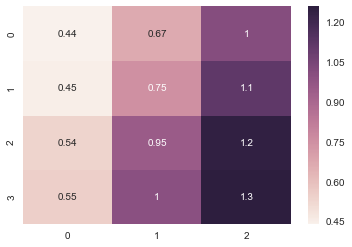

In [57]:
#Visualization results trained word embeddings
%matplotlib inline

import numpy as np
import seaborn as sns

ax = sns.heatmap(mappingArray,  annot=True)

# 4. Interpretation results of the visualization

As the analogy function that we created is based on Euclidian distance, the lower the value, the better the semantic relationships have been conserved. From the heatmap we can see that the distances are the lowest for CBOW without extra hidden layer. The relationships within a model between any two embedding sizes seem to be almost linear, regardless of the model you are looking at. 

Another thing that jumps out is that the Skipgram models of embedding vector size 50 seem to find similar values to the CBOW models with embedding size 150. A similar effect is seen between CBOW 300 and Skipgram 150. 

It is important to note however, that all distances seem relatively small anyway. In fact, the characteristic that some models find higher distances does not mean that these models are less accurate. It may well be the case that the "true" analogy value of the analogy chosen in the previous question is closer to a value of 1, as found by the models with larger embedding vectors.

# 5 Compare the results of the trained word embeddings with the word-word co-occurrence matrix

Code can be found below.

Discussion of the advantages of CBOW and Skipgram, the advantages of negative sampling and drawbacks of CBOW and Skipgram

In [149]:
#load pretrained word embeddings of word2vec

path_word2vec = "your path /GoogleNews-vectors-negative300.bin"

word2vec = KeyedVectors.load_word2vec_format(path, binary=True)

ValueError: not enough values to unpack (expected 2, got 0)

In [ ]:
#load pretraind word embeddings of Glove

path = "your path /glove.6B/glove.6B.300d_converted.txt"

#convert GloVe into word2vec format
gensim.scripts.glove2word2vec.get_glove_info(path)
gensim.scripts.glove2word2vec.glove2word2vec(path, "glove_converted.txt")

glove = KeyedVectors.load_word2vec_format(path, binary=False)

In [ ]:
#Visualize the pre-trained word embeddings

Comparison performance with your own trained word embeddings